In [5]:
#Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import re

# Modeling


In [3]:
# Data paths
PATH_TRAIN = "data/train_2_pr.csv"
PATH_COMP  = "data/shipping_companies_details_1.csv"
PATH_SUB   = "data/submission_2.csv"


In [7]:
# Load Data
train = pd.read_csv(PATH_TRAIN)
companies = pd.read_csv(PATH_COMP)
submission = pd.read_csv(PATH_SUB)

print("Shapes -> train:", train.shape, "companies:", companies.shape, "submission:", submission.shape)
print("\nTrain columns:", list(train.columns))


Shapes -> train: (5114, 14) companies: (5, 12) submission: (1260, 2)

Train columns: ['Unnamed: 0', 'shipment_id', 'send_timestamp', 'pick_up_point', 'drop_off_point', 'source_country', 'destination_country', 'freight_cost', 'gross_weight', 'shipment_charges', 'shipment_mode', 'shipping_company', 'selected', 'shipping_time']


In [9]:
# Basic Cleaning
def strip_whitespace_df(df: pd.DataFrame) -> pd.DataFrame:
    for c in df.select_dtypes(include="object").columns:
        df[c] = df[c].astype(str).str.strip()
    return df

train = strip_whitespace_df(train)
companies = strip_whitespace_df(companies)

In [11]:
# Parse datetime
if "send_timestamp" in train.columns:
    train["send_timestamp"] = pd.to_datetime(train["send_timestamp"], errors="coerce")

# Coerce numerics in train
for c in ["freight_cost", "gross_weight", "shipment_charges", "shipping_time"]:
    if c in train.columns:
        train[c] = pd.to_numeric(train[c], errors="coerce")

In [13]:
# Sanitize company numeric columns (commas/spaces -> float)
def to_numeric_sanitize(x):
    if pd.isna(x): return np.nan
    x = re.sub(r"[,\s]", "", str(x))
    try:
        return float(x)
    except:
        return np.nan

for c in ["min_cs", "max_cs", "shipment_charges", "expected_turnaround_time", "max_turnaround_time_tat"]:
    if c in companies.columns:
        companies[c] = companies[c].apply(to_numeric_sanitize)

In [15]:
# ---------- 3) Merge company details (enrichment) ----------
join_keys = [k for k in ["shipping_company", "pick_up_point", "drop_off_point"] if k in train.columns and k in companies.columns]
merged = train.merge(companies, how="left", on=join_keys, suffixes=("", "_cmp"))
print("\nMerged shape:", merged.shape)

# ---------- 4) Quick schema/preview ----------
print("\nMerged dtypes:\n", merged.dtypes)
print("\nMerged head():")
display(merged.head(5))


Merged shape: (5114, 23)

Merged dtypes:
 Unnamed: 0                          int64
shipment_id                        object
send_timestamp             datetime64[ns]
pick_up_point                      object
drop_off_point                     object
source_country                     object
destination_country                object
freight_cost                      float64
gross_weight                      float64
shipment_charges                  float64
shipment_mode                      object
shipping_company                   object
selected                           object
shipping_time                     float64
source_country_cmp                 object
destination_country_cmp            object
shipment_mode_cmp                  object
cut_off_time                       object
tat                                object
processing_days                    object
min_cs                            float64
max_cs                            float64
shipment_charges_cmp             

,Unnamed: 0,shipment_id,send_timestamp,pick_up_point,drop_off_point,source_country,destination_country,freight_cost,gross_weight,shipment_charges,...,shipping_time,source_country_cmp,destination_country_cmp,shipment_mode_cmp,cut_off_time,tat,processing_days,min_cs,max_cs,shipment_charges_cmp
0,0,S000720,2019-06-08 07:17:51,A,Y,GB,IN,88.61,355.0,0.75,...,5.00741,GB,IN,Air,24/7,Within 15 mins,24/7,100.0,200000.0,0.75
1,1,S000725,2019-07-12 15:23:21,A,Y,GB,IN,85.65,105.0,0.90,...,21.41215,GB,IN,Ocean,12PM IST,Before CO - T+0\nAfter CO - T+1,Mon-Fri,100.0,2500000.0,0.90
2,2,S000736,2019-10-04 14:23:29,A,Y,GB,IN,86.22,100.0,0.75,...,5.33692,GB,IN,Air,24/7,Within 15 mins,24/7,100.0,200000.0,0.75
3,3,S000738,2020-01-07 09:19:50,A,Y,GB,IN,94.43,1071.0,1.05,...,5.14792,GB,IN,Air,24/7,Real-time,24/7,100.0,200000.0,1.05
4,4,S000739,2020-04-11 06:36:03,A,Y,GB,IN,94.24,2007.0,0.75,...,5.03067,GB,IN,Air,24/7,Within 15 mins,24/7,100.0,200000.0,0.75


In [17]:
missing = (
    merged.isna()
    .mean()
    .sort_values(ascending=False)
    .rename("missing_fraction")
    .reset_index()
    .rename(columns={"index":"column"})
)
display(missing)

,column,missing_fraction
0,Unnamed: 0,0.0
1,selected,0.0
2,max_cs,0.0
3,min_cs,0.0
4,processing_days,0.0
5,tat,0.0
6,cut_off_time,0.0
7,shipment_mode_cmp,0.0
8,destination_country_cmp,0.0
9,source_country_cmp,0.0


In [19]:
# ---------- 6) Simple feature engineering (time parts) ----------
if "send_timestamp" in merged.columns:
    merged["send_year"]  = merged["send_timestamp"].dt.year
    merged["send_month"] = merged["send_timestamp"].dt.month
    merged["send_day"]   = merged["send_timestamp"].dt.day
    merged["send_hour"]  = merged["send_timestamp"].dt.hour

In [21]:
# ---------- 7) Target checks ----------
target = "shipping_time"
if target not in merged.columns:
    raise ValueError("Target `shipping_time` not found.")

print("\nTarget summary (shipping_time):")
print(merged[target].describe())


Target summary (shipping_time):
count    5114.000000
mean       12.641822
std        10.273164
min         5.000000
25%         5.199910
50%         5.405150
75%        19.644270
max        57.249650
Name: shipping_time, dtype: float64


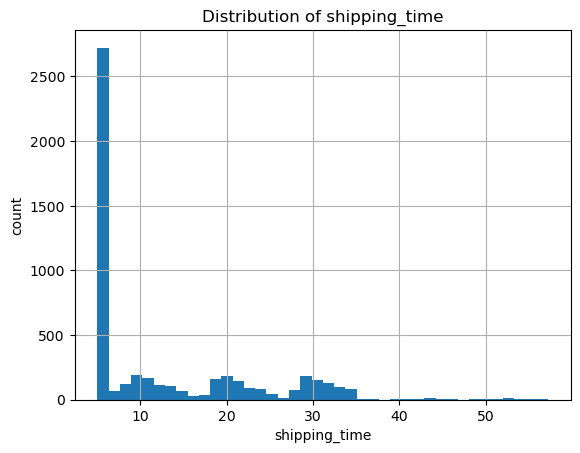

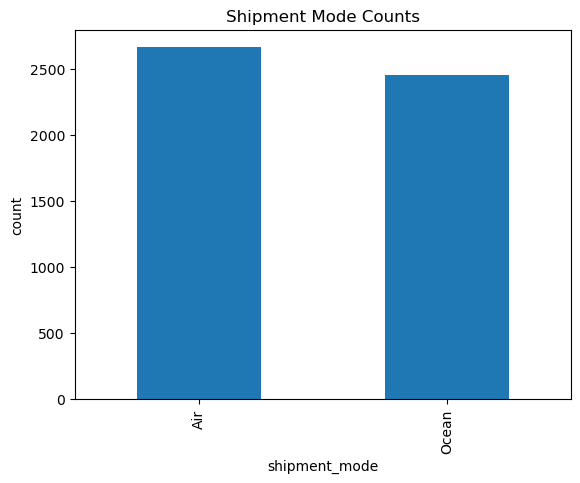

C:\Users\jingl\AppData\Local\Temp\ipykernel_3172\3569680686.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order)


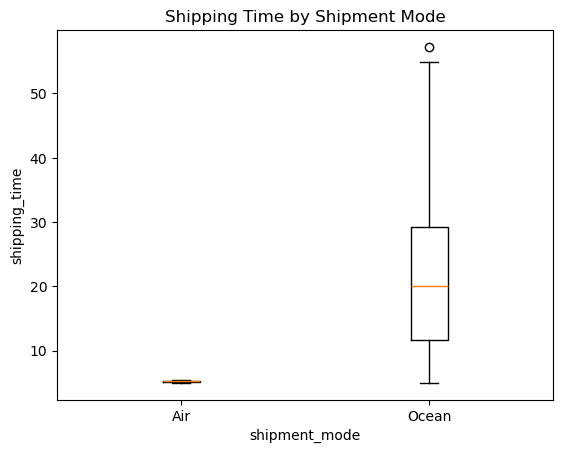

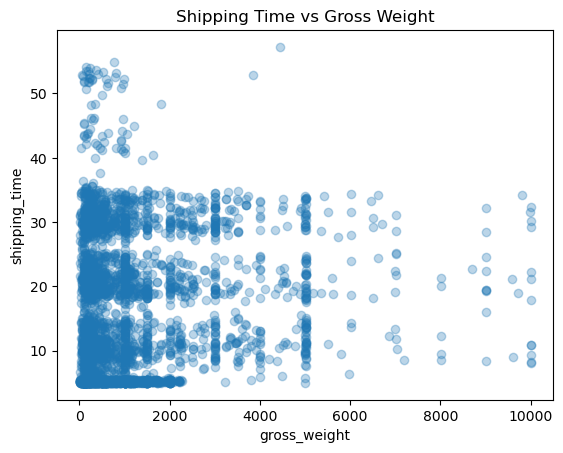

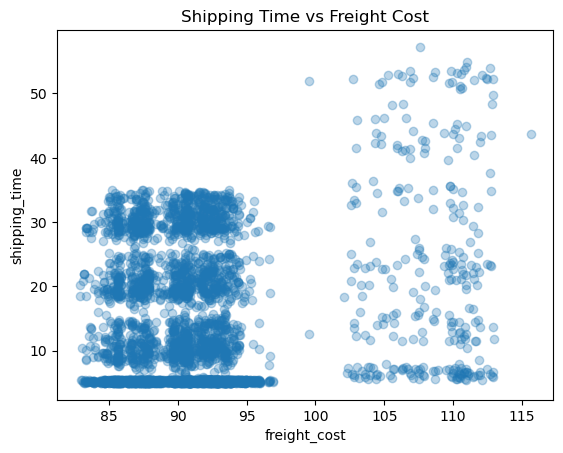


Route/Mode/Company summary (top 15 by size):


,shipment_mode,shipping_company,pick_up_point,drop_off_point,count,mean,median,std
3,Ocean,SC1,A,Y,2153,20.346952,19.968750,8.516735
1,Air,SC3,A,Y,1656,5.212321,5.213945,0.124272
0,Air,SC2,A,Y,1008,5.208812,5.203125,0.119686
4,Ocean,SC2,A,X,203,22.364996,19.647570,15.410839
2,Ocean,SC1,A,X,94,25.756490,22.396005,16.470045



Numeric correlation with target (top 15):


max_cs                  0.745563
Unnamed: 0              0.268320
gross_weight            0.208362
freight_cost            0.172070
send_hour               0.068586
shipment_charges        0.049514
shipment_charges_cmp    0.049514
send_day                0.035705
send_month              0.031913
send_year              -0.141686
min_cs                 -0.260984
Name: shipping_time, dtype: float64


EDA complete. Next step: model baselines.


In [25]:
# ---------- 8) Plots (matplotlib only) ----------
plt.figure()
merged[target].dropna().hist(bins=40)
plt.title("Distribution of shipping_time")
plt.xlabel("shipping_time")
plt.ylabel("count")
plt.show()

# Counts by shipment_mode
if "shipment_mode" in merged.columns:
    plt.figure()
    merged["shipment_mode"].value_counts(dropna=False).plot(kind="bar")
    plt.title("Shipment Mode Counts")
    plt.xlabel("shipment_mode")
    plt.ylabel("count")
    plt.show()

# Boxplot: shipping_time by shipment_mode
if "shipment_mode" in merged.columns:
    order = list(merged["shipment_mode"].dropna().unique())
    data = [merged.loc[merged["shipment_mode"] == m, target].dropna().values for m in order]
    if len(data) > 0:
        plt.figure()
        plt.boxplot(data, labels=order)
        plt.title("Shipping Time by Shipment Mode")
        plt.xlabel("shipment_mode")
        plt.ylabel("shipping_time")
        plt.show()

# Scatter: shipping_time vs gross_weight
if "gross_weight" in merged.columns:
    plt.figure()
    plt.scatter(merged["gross_weight"], merged[target], alpha=0.3)
    plt.title("Shipping Time vs Gross Weight")
    plt.xlabel("gross_weight")
    plt.ylabel("shipping_time")
    plt.show()

# Scatter: shipping_time vs freight_cost
if "freight_cost" in merged.columns:
    plt.figure()
    plt.scatter(merged["freight_cost"], merged[target], alpha=0.3)
    plt.title("Shipping Time vs Freight Cost")
    plt.xlabel("freight_cost")
    plt.ylabel("shipping_time")
    plt.show()

# ---------- 9) Grouped summaries (route/mode/company) ----------
group_cols = [c for c in ["shipment_mode", "shipping_company", "pick_up_point", "drop_off_point"] if c in merged.columns]
if group_cols:
    grp = merged.groupby(group_cols)[target].agg(["count","mean","median","std"]).reset_index().sort_values("count", ascending=False)
    print("\nRoute/Mode/Company summary (top 15 by size):")
    display(grp.head(15))

# ---------- 10) Numeric correlations (quick view) ----------
num_cols = merged.select_dtypes(include=[np.number]).columns.tolist()
if target in num_cols and len(num_cols) > 1:
    corr = merged[num_cols].corr(numeric_only=True)
    print("\nNumeric correlation with target (top 15):")
    target_corr = corr[target].drop(labels=[target]).sort_values(ascending=False)
    display(target_corr.head(15))

print("\nEDA complete. Next step: model baselines.")